In [62]:
# Tratamiento de datos
# ==============================================================================
import warnings
import shap
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import TimeSeriesFold
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import sklearn
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================


# Configuración warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.15.1
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.3
Versión numpy: 2.1.3


In [25]:
try:
    datos_ini = pd.read_csv("../output/Datos_Fusionadosv1.csv")


except Exception as e:
    print(f"Error al cargar los datos: {str(e)}")

# Test proceso con equipo 1

In [26]:
datos  = datos_ini[datos_ini['ID_Equipo'] == 1]

In [66]:

# Seleccionar variables relevantes
variables_relevantes = ['Temperatura_C', 'Vibracion_mm_s', 'Horas_Operativas', 'Horas_Recomendadas_Revision']

# Aplicar PCA para reducir dimensiones
pca = PCA(n_components=0.95) # Conservar 95% de la varianza
datos_pca = pca.fit_transform(datos[variables_relevantes])

# Convertir el resultado de PCA a un DataFrame
datos_pca = pd.DataFrame(datos_pca, index=datos.index, columns=[f'PC{i+1}' for i in range(datos_pca.shape[1])])

# Mostrar las primeras filas del dataframe transformado
print(datos_pca.head())


                          PC1
Fecha_Condiciones            
2021-01-01         365.472079
2021-01-02         385.320339
2021-01-03         409.413021
2021-01-04         415.373300
2021-01-05         434.299484


In [49]:
datos.head()

,ID_Equipo,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Horas_Recomendadas_Revision,Tipo_Mantenimiento
Fecha_Condiciones,,,,,,
2021-01-01,1,34.749896,2.136812,614,913,sin
2021-01-02,1,89.588937,9.409404,634,913,sin
2021-01-03,1,56.200558,1.529395,658,913,sin
2021-01-04,1,70.555608,3.411009,664,913,sin
2021-01-05,1,97.509000,0.618757,683,913,sin


Fechas train : 2021-01-01 00:00:00 --- 2024-03-06 00:00:00 (n=1161)
Fechas test : 2024-03-07 00:00:00 --- 2024-12-31 00:00:00 (n=300)


<Axes: xlabel='Fecha_Condiciones'>

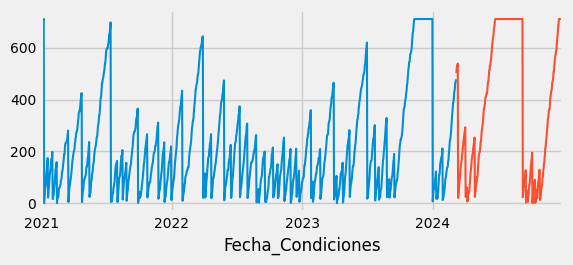

In [77]:

# Separación datos train-test
steps = 300 # Predecir 15 días antes de un fallo
datos_train = datos[:-steps]
datos_test = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()} (n={len(datos_train)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()} (n={len(datos_test)})")

# Visualización de los datos
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')


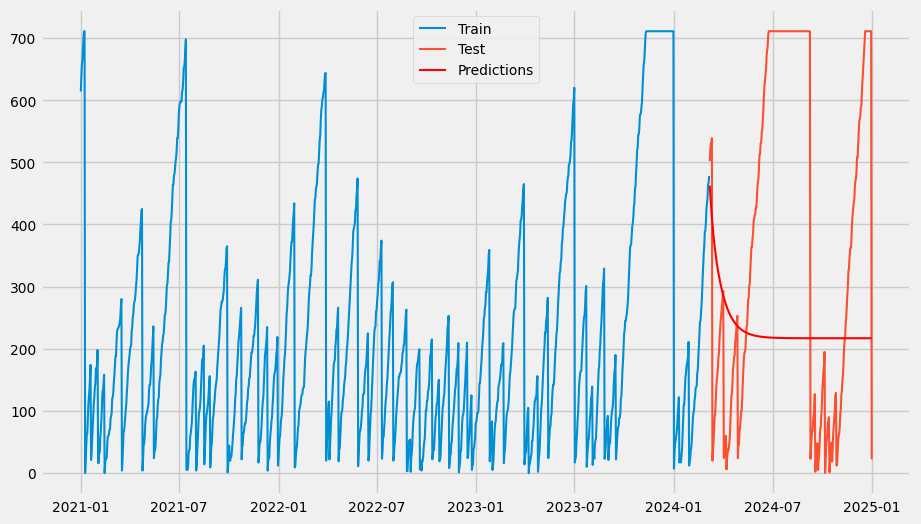

In [78]:

# Entrenar el modelo autoregresivo
model = AutoReg(datos_train['Horas_Operativas'], lags=15)
model_fit = model.fit()

# Realizar la predicción
predictions = model_fit.predict(start=len(datos_train), end=len(datos_train) + len(datos_test) - 1, dynamic=False)

# Comparar las predicciones con los datos reales
plt.figure(figsize=(10, 6))
plt.plot(datos_train.index, datos_train['Horas_Operativas'], label='Train')
plt.plot(datos_test.index, datos_test['Horas_Operativas'], label='Test')
plt.plot(datos_test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.show()


In [80]:


# Definir el umbral para las horas recomendadas de revisión
umbral_revision = datos['Horas_Recomendadas_Revision'].mean()

# Convertir las horas operativas predichas en una variable categórica
predictions_categoricas = (predictions > umbral_revision).astype(int)
datos_test_categoricas = (datos_test['Horas_Operativas'] > umbral_revision).astype(int)

# Calcular accuracy y f1 score
accuracy = accuracy_score(datos_test_categoricas, predictions_categoricas)
f1 = f1_score(datos_test_categoricas, predictions_categoricas)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')



Accuracy: 1.00
F1 Score: 0.00


c:\Users\UF775634\AppData\Local\anaconda3\envs\Netmind\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


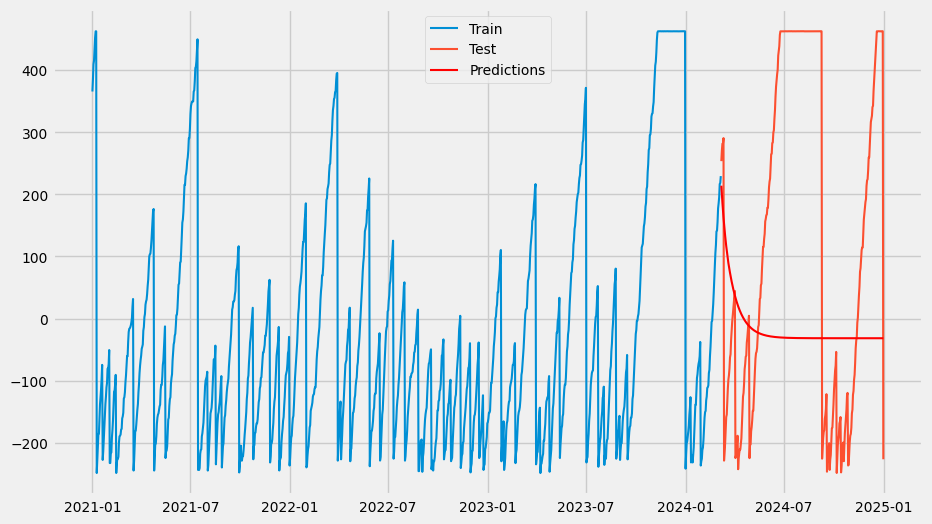

In [82]:

# Separación datos train-test
steps = 300
datos_train = datos_pca[:-steps]
datos_test = datos_pca[-steps:]

# Entrenar el modelo autoregresivo
model = AutoReg(datos_train['PC1'], lags=15)
model_fit = model.fit()

# Realizar la predicción
predictions = model_fit.predict(start=len(datos_train), end=len(datos_train) + len(datos_test) - 1, dynamic=False)


# Comparar las predicciones con los datos reales
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(datos_train.index, datos_train['PC1'], label='Train')
plt.plot(datos_test.index, datos_test['PC1'], label='Test')
plt.plot(datos_test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.show()


In [83]:

# Generar la variable objetivo (fallo en los próximos 15 días)
datos['Fallo'] = datos['Tipo_Mantenimiento'].shift(-15).fillna('sin') != 'sin'

# Separar características y variable objetivo
X = datos_pca
y = datos['Fallo']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de clasificación
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Realizar predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.87
F1 Score: 0.05


In [84]:

# Definir los parámetros para Grid Search
param_grid = {
     'n_estimators': [100, 200, 300],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

# Realizar Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f'Best Accuracy: {accuracy_best:.2f}')


Best Accuracy: 0.87



# Preparacion



In [ ]:
# Preparación del dato
datos['Fecha_Condiciones'] = pd.to_datetime(datos['Fecha_Condiciones'], format='%Y-%m-%d')
datos = datos.drop_duplicates(subset='Fecha_Condiciones')  # Eliminar duplicados
datos = datos.set_index('Fecha_Condiciones')
datos = datos.asfreq('D')  # Convierte Timeseries a frecuencia diaria
datos = datos.sort_index()

# Mostrar las primeras filas del dataframe
print(datos.head())



                   ID_Equipo  Temperatura_C  Vibracion_mm_s  Horas_Operativas  \
Fecha_Condiciones                                                               
2021-01-01                 1      34.749896        2.136812               614   
2021-01-02                 1      89.588937        9.409404               634   
2021-01-03                 1      56.200558        1.529395               658   
2021-01-04                 1      70.555608        3.411009               664   
2021-01-05                 1      97.509000        0.618757               683   

                   Horas_Recomendadas_Revision Tipo_Mantenimiento  
Fecha_Condiciones                                                  
2021-01-01                                 913                sin  
2021-01-02                                 913                sin  
2021-01-03                                 913                sin  
2021-01-04                                 913                sin  
2021-01-05              

C:\Users\UF775634\AppData\Local\Temp\ipykernel_26700\3936819561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['Fecha_Condiciones'] = pd.to_datetime(datos['Fecha_Condiciones'], format='%Y-%m-%d')


Fechas train : 2021-01-01 00:00:00 --- 2023-05-11 00:00:00  (n=861)
Fechas test : 2023-05-12 00:00:00 --- 2024-12-31 00:00:00  (n=600)


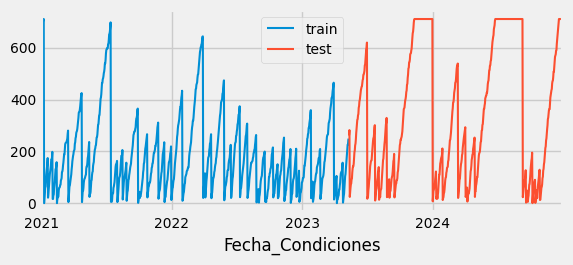

In [86]:
# Separación datos train-test


steps = 600
datos_train = datos[:-steps]
datos_test = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Visualización de los datos
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend()
plt.show()


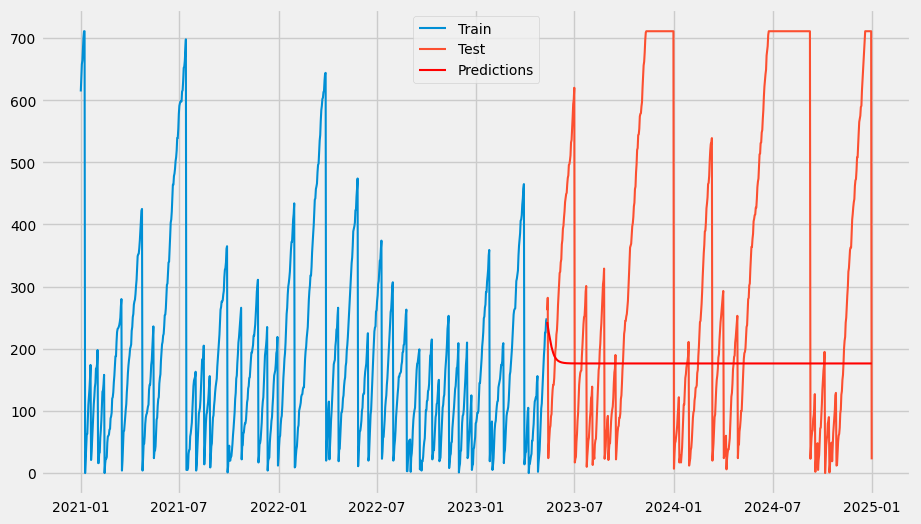

In [87]:

# Entrenar el modelo autoregresivo
model = AutoReg(datos_train['Horas_Operativas'], lags=15)
model_fit = model.fit()

# Realizar la predicción
predictions = model_fit.predict(start=len(datos_train), end=len(datos_train) + len(datos_test) - 1, dynamic=False)

# Comparar las predicciones con los datos reales
plt.figure(figsize=(10, 6))
plt.plot(datos_train.index, datos_train['Horas_Operativas'], label='Train')
plt.plot(datos_test.index, datos_test['Horas_Operativas'], label='Test')
plt.plot(datos_test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.show()


In [97]:
steps = 600
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2024-12-20    674.81
2024-12-21    706.93
2024-12-22    476.98
2024-12-23    386.11
2024-12-24    259.91
Freq: D, Name: pred, dtype: float64

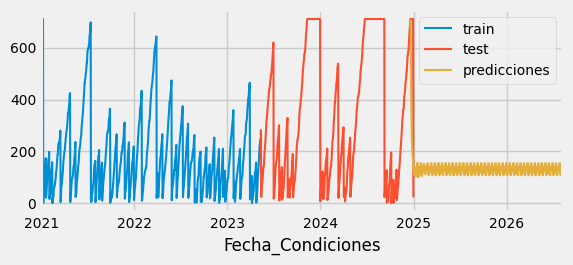

In [98]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [99]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 116933.233354
